In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import spacy
import nltk
from nltk import FreqDist
import pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim import corpora
import gender_guesser.detector as gender
import seaborn as sns
import matplotlib.pyplot as plt

from utils import load_results_json

pd.set_option("display.max_colwidth", 200)

C:\Users\dbarker3\myAnaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Load Data

Create an instance of the gender detector so that we can use it to create a new column estimating gender from the reviewer's first name.

In [3]:
gd = gender.Detector(case_sensitive=False)

In [4]:
JSON_FILE = "data/results_5716reviews.json"

In [5]:
data = load_results_json(JSON_FILE)
print(f"Number of reviews loaded: {len(data)}")

Number of reviews loaded: 5716


### Create dataframe and new derived columns

In [6]:
df = pd.read_json(JSON_FILE)

# Split full names into first/last names
full_names = df['name'].str.split(" ", n=1, expand=True)
df['first_name'] = full_names[0]
df['last_name'] = full_names[1]
df.drop(columns=['name'], inplace=True)

# Guess the gender based on first name
df['guessed_gender'] = df['first_name'].apply(gd.get_gender)

In [7]:
display(df.head())
display(df.tail())

,date,text,stars,vivino_response,first_name,last_name,guessed_gender
0,2020-01-15,Super easy to use and very practical. I love wine and I love GOOD wine but I'm new in this business and so like to experience different types. If you want to experiment a bit or just do a quick se...,"[5, 5]",,Dasha,Tuzova,unknown
1,2020-01-27,"Overall I like the app. However one niggle relates to adding the location where I purchased the wine. Why can I not specify a location for the wine I purchase, without allowing access to my curren...","[4, 5]",,Paul,de Cort,male
2,2020-01-16,"It's quite simply a really useful app to keep track of the wines you've drunk, and though this log and the ratings you give the wines, it'll recommend you other wines in various price groups. It'l...","[5, 5]",,Finn,None,male
3,2020-01-27,"I use this app mostly when I randomly browsing the wine section of grocery stores and wine shops. Take a picture of the bottle, and you can see the price and reviews. Really helpful when you must ...","[5, 5]",,Helenia,Pan,unknown
4,2020-01-23,Great app to get good views on new wines. Great app to determine relative cost for a wine I am considering. Also a good app to provide recommendations for wines similar to the wines I like. VIVINO...,"[5, 5]",,Bob,Junk,male


,date,text,stars,vivino_response,first_name,last_name,guessed_gender
5711,2015-04-24,Great app This is a great tool. I've been slowly acquiring a taste for wine over the last 10 years. The app is awesome I can just snap a pic and store great wines on my travels.,"[5, 5]",,T,Jackson,unknown
5712,2015-03-23,Love it! Would give a 5 star but having issue with the flash in low level lighting. Does not work! Also maybe giving a limited access to cellar function for free!,"[4, 5]",,Peter,Keating,male
5713,2015-04-08,"Nice! This is a great app. It's a good way to keep track of the wines you love and to look for new ones to try. I love the ""My taste profile"" feature! Very nice interface.","[5, 5]",,Destiny,Gaines,female
5714,2015-03-21,I guess sake is not a wine as evaluated by this app. Need to find an app that works out of the box.,"[1, 5]",,Chris,Vanslager,mostly_male
5715,2015-03-27,"It is good but slow. The idea of app is amasing, but slow from time to time.New update fast it up a bit but it still need work. Results of the photo is offeten false.","[5, 5]",,Vlado,Medin,male


## User Demographics

### Plot estimated gender as implied by first name

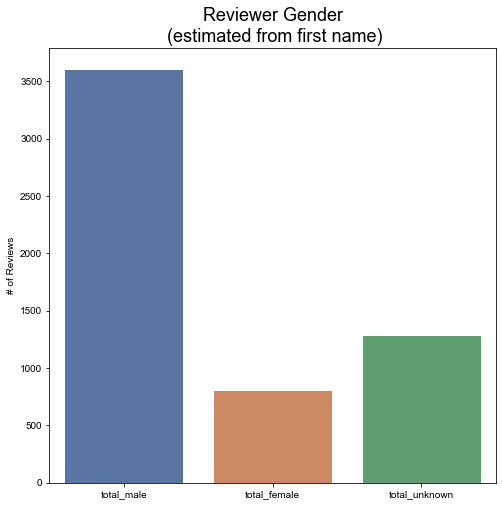

In [8]:
# display(df['guessed_gender'].value_counts())

fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1.5)

df_gndr = df['guessed_gender'].value_counts()
df_gndr['total_male'] = df_gndr['male'] + df_gndr['mostly_male']
df_gndr['total_female'] = df_gndr['female'] + df_gndr['mostly_female']
df_gndr['total_unknown'] = df_gndr['unknown'] + df_gndr['andy']
df_gndr = df_gndr.drop(index=['male', 'female', 'unknown', 'mostly_male', 'mostly_female', 'andy'])
# display(df_gndr)
ax = sns.barplot(x=df_gndr.index, y=df_gndr.values)
ax.set_title("Reviewer Gender\n (estimated from first name)")
ax.set_ylabel('# of Reviews')

plt.savefig("outputs/estimaged_gender.png")
sns.set(font_scale=1.5)
plt.show()
plt.close()


## Task Investigation

Objective here is to understand what users are using the app for.

### Data preprocessing

In [9]:
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dbarker3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [129]:
# stop_words = stopwords.words('english')
stop_words = STOP_WORDS


def remove_stopwords(x):
    """ Remove common stopwords from the review text. """
    txt = " ".join([t for t in x if t not in stop_words])
    return txt


def remove_short_words(x, min_length=3):
    """ Remove words with less than certain length. """
    word = ' '.join([w for w in x.split() if len(w) >= min_length])
    return word

```App``` and ```Wine``` are common words appearing the review (obviously), but not terribly informative. We'll add these to our stopwords.

In [130]:
stop_words.add('app')
stop_words.add('apps')
stop_words.add('wine')
stop_words.add('wines')
stop_words.add('vivino')

In [131]:
len(stop_words)

331

In [132]:
df['clean_text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
clean_reviews1 = df['clean_text'].apply(remove_short_words)
clean_reviews2 = [r.lower() for r in clean_reviews1]
clean_reviews3 = [remove_stopwords(r.split()) for r in clean_reviews2]
# clean_reviews3 = [r.lower() for r in clean_reviews2]
df['clean_text'] = clean_reviews3
display(df.head())
display(df.tail())

,date,text,stars,vivino_response,first_name,last_name,guessed_gender,clean_text,review_lemmas
0,2020-01-15,Super easy to use and very practical. I love wine and I love GOOD wine but I'm new in this business and so like to experience different types. If you want to experiment a bit or just do a quick se...,"[5, 5]",,Dasha,Tuzova,unknown,super easy use practical love love good new business like experience different types want experiment bit quick search contemplating lot useful features like sales news,business experience type experiment search contemplate feature sale
1,2020-01-27,"Overall I like the app. However one niggle relates to adding the location where I purchased the wine. Why can I not specify a location for the wine I purchase, without allowing access to my curren...","[4, 5]",,Paul,de Cort,male,overall like niggle relates adding location purchased specify location purchase allowing access current location don usually add list supermarket buy location drink irrelevant purchased allow sear...,relate add purchase location purchase allow access location location purchase allow search location location thank
2,2020-01-16,"It's quite simply a really useful app to keep track of the wines you've drunk, and though this log and the ratings you give the wines, it'll recommend you other wines in various price groups. It'l...","[5, 5]",,Finn,None,male,simply useful track drunk log ratings recommend price groups build taste profile based drink like regions nice,track rating recommend price group build taste profile base drink region
3,2020-01-27,"I use this app mostly when I randomly browsing the wine section of grocery stores and wine shops. Take a picture of the bottle, and you can see the price and reviews. Really helpful when you must ...","[5, 5]",,Helenia,Pan,unknown,use randomly browsing section grocery stores shops picture bottle price reviews helpful bottle hurry,browse section grocery store shop picture bottle price review bottle hurry
4,2020-01-23,Great app to get good views on new wines. Great app to determine relative cost for a wine I am considering. Also a good app to provide recommendations for wines similar to the wines I like. VIVINO...,"[5, 5]",,Bob,Junk,male,great good views new great determine relative cost considering good provide recommendations similar like favorite recommended thanked,view determine considering provide recommendation recommend thank


,date,text,stars,vivino_response,first_name,last_name,guessed_gender,clean_text,review_lemmas
5711,2015-04-24,Great app This is a great tool. I've been slowly acquiring a taste for wine over the last 10 years. The app is awesome I can just snap a pic and store great wines on my travels.,"[5, 5]",,T,Jackson,unknown,great great tool slowly acquiring taste years awesome snap pic store great travels,acquire taste year store travel
5712,2015-03-23,Love it! Would give a 5 star but having issue with the flash in low level lighting. Does not work! Also maybe giving a limited access to cellar function for free!,"[4, 5]",,Peter,Keating,male,love star having issue flash low level lighting work maybe giving limited access cellar function free,have issue flash level light give access function
5713,2015-04-08,"Nice! This is a great app. It's a good way to keep track of the wines you love and to look for new ones to try. I love the ""My taste profile"" feature! Very nice interface.","[5, 5]",,Destiny,Gaines,female,nice great good way track love look new ones try love taste profile feature nice interface,track taste profile feature interface
5714,2015-03-21,I guess sake is not a wine as evaluated by this app. Need to find an app that works out of the box.,"[1, 5]",,Chris,Vanslager,mostly_male,guess sake evaluated need find works box,evaluate work
5715,2015-03-27,"It is good but slow. The idea of app is amasing, but slow from time to time.New update fast it up a bit but it still need work. Results of the photo is offeten false.","[5, 5]",,Vlado,Medin,male,good slow idea amasing slow time time new update fast bit need work results photo offeten false,amase update result photo offeten


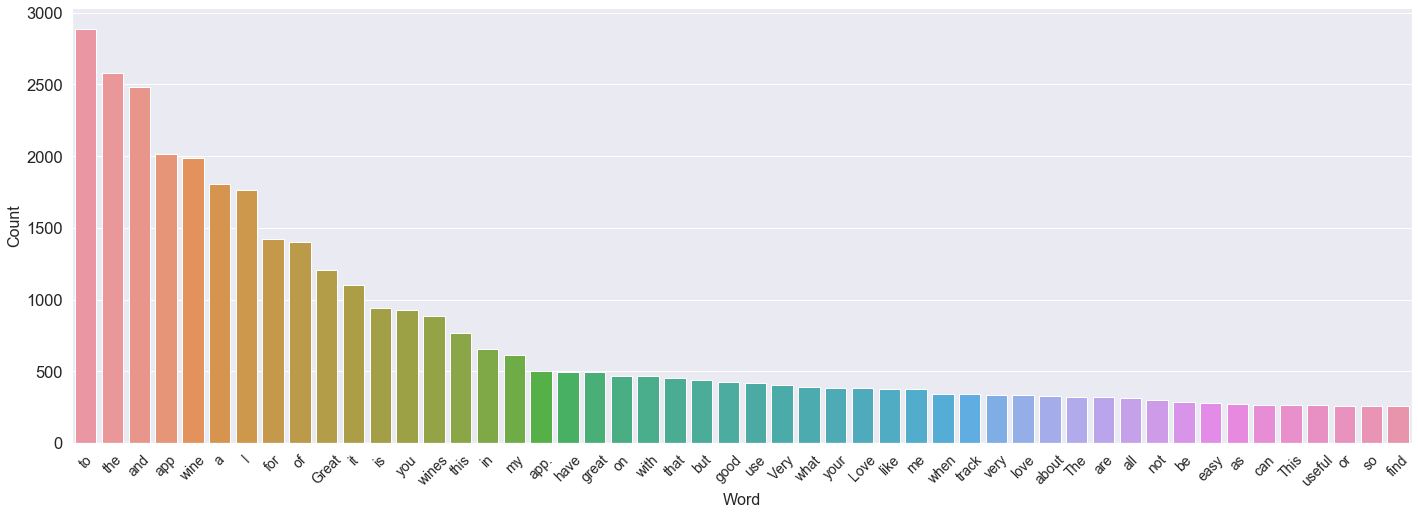

In [133]:
def most_freq_words(x, terms=25):
    """ Plot the most frequent review terms. """
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    df_words = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})
    
    d = df_words.nlargest(columns='count', n=terms)
    # display(d)
    
    fig, ax = plt.subplots(figsize=(24,8))
    sns.barplot(x='word', y='count', data=d, ax=ax)
    ax.set_ylabel('Count', fontsize=16)
    plt.xticks(rotation=45, fontsize=14)
    ax.set_xlabel('Word', fontsize=16)
    plt.show()
    plt.close()
    
    
most_freq_words(df['text'], 50)

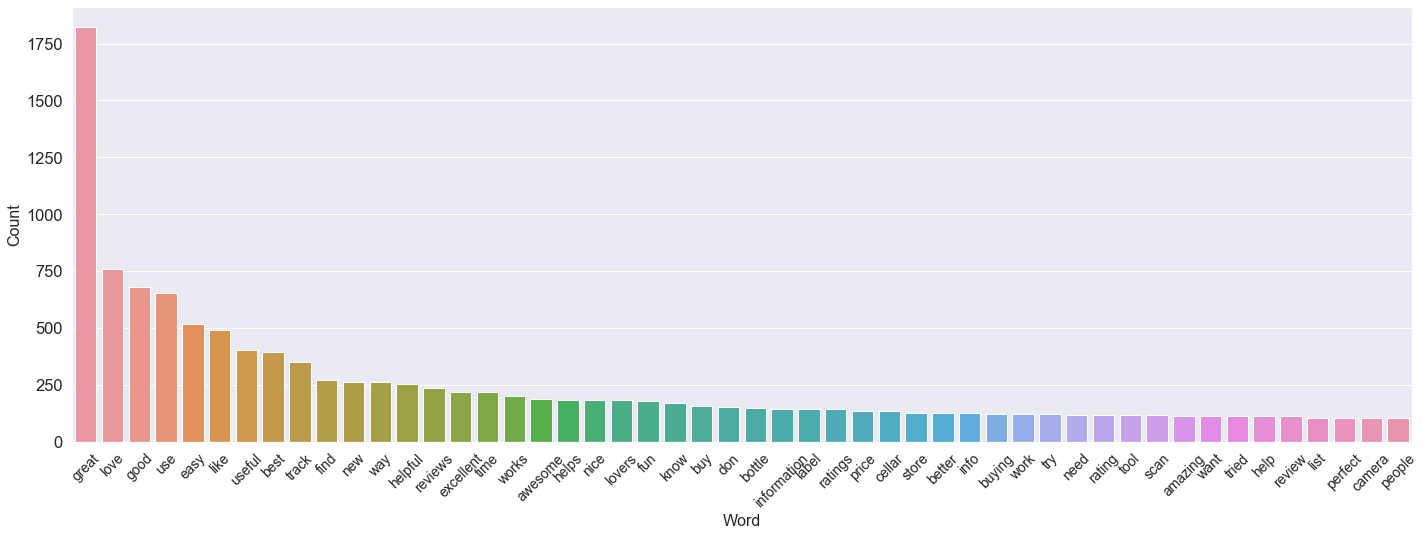

In [134]:
most_freq_words(df['clean_text'], 50)

### Perform NLP

In [135]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']):
    """ Create lemmas from our product review text. """
    output = []
    for review in texts:
        doc = nlp(" ".join(review))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [140]:
tokenized_reviews = pd.Series(df['clean_text']).apply(lambda x: x.split())
print(tokenized_reviews[0])

review_lemmas = lemmatization(tokenized_reviews, tags=['VERB'])
# review_lemmas = lemmatization(tokenized_reviews, tags=['NOUN', 'VERB'])
# review_lemmas = lemmatization(tokenized_reviews, tags=['NOUN', 'VERB', 'ADJ', 'ADV'])
print(review_lemmas[0])

['super', 'easy', 'use', 'practical', 'love', 'love', 'good', 'new', 'business', 'like', 'experience', 'different', 'types', 'want', 'experiment', 'bit', 'quick', 'search', 'contemplating', 'lot', 'useful', 'features', 'like', 'sales', 'news']
['use', 'want', 'contemplate']


In [141]:
review_lemmas2 = []
for i in range(len(review_lemmas)):
    review_lemmas2.append(' '.join(review_lemmas[i]))
    
df['review_lemmas'] = review_lemmas2

In [158]:
print(review_lemmas[0])
min_lemma_length = 5

review_lemmas_filtered = []
for lemmas in review_lemmas:
    rf = [r for r in lemmas if len(r) >= min_lemma_length]
    review_lemmas_filtered.append(rf)
print(review_lemmas_filtered[0])

['use', 'want', 'contemplate']
['contemplate']


In [160]:
df.head()

,date,text,stars,vivino_response,first_name,last_name,guessed_gender,clean_text,review_lemmas
0,2020-01-15,Super easy to use and very practical. I love wine and I love GOOD wine but I'm new in this business and so like to experience different types. If you want to experiment a bit or just do a quick se...,"[5, 5]",,Dasha,Tuzova,unknown,super easy use practical love love good new business like experience different types want experiment bit quick search contemplating lot useful features like sales news,use want contemplate
1,2020-01-27,"Overall I like the app. However one niggle relates to adding the location where I purchased the wine. Why can I not specify a location for the wine I purchase, without allowing access to my curren...","[4, 5]",,Paul,de Cort,male,overall like niggle relates adding location purchased specify location purchase allowing access current location don usually add list supermarket buy location drink irrelevant purchased allow sear...,relate add purchase allow add purchase allow need know
2,2020-01-16,"It's quite simply a really useful app to keep track of the wines you've drunk, and though this log and the ratings you give the wines, it'll recommend you other wines in various price groups. It'l...","[5, 5]",,Finn,None,male,simply useful track drunk log ratings recommend price groups build taste profile based drink like regions nice,recommend build base
3,2020-01-27,"I use this app mostly when I randomly browsing the wine section of grocery stores and wine shops. Take a picture of the bottle, and you can see the price and reviews. Really helpful when you must ...","[5, 5]",,Helenia,Pan,unknown,use randomly browsing section grocery stores shops picture bottle price reviews helpful bottle hurry,use browse shop
4,2020-01-23,Great app to get good views on new wines. Great app to determine relative cost for a wine I am considering. Also a good app to provide recommendations for wines similar to the wines I like. VIVINO...,"[5, 5]",,Bob,Junk,male,great good views new great determine relative cost considering good provide recommendations similar like favorite recommended thanked,consider recommend thank


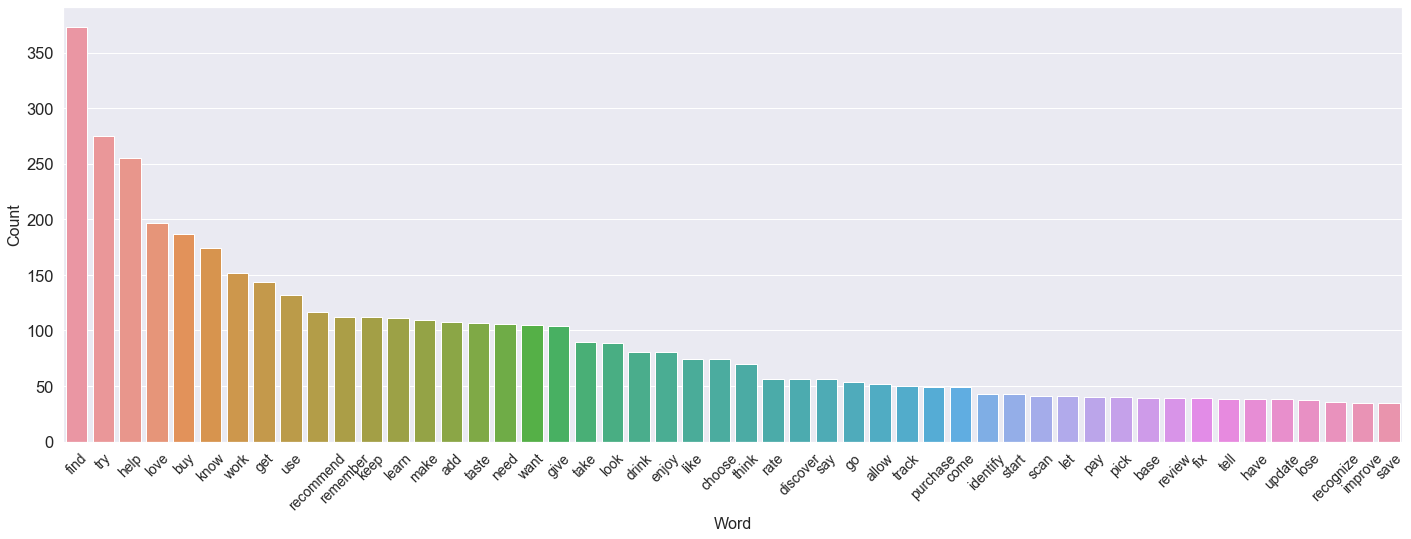

In [143]:
most_freq_words(df['review_lemmas'], 50)

### Build LDA Model

In [161]:
dictionary = corpora.Dictionary(review_lemmas_filtered)

In [162]:
doc_term_matrix = [dictionary.doc2bow(review) for review in review_lemmas_filtered]

In [167]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100, chunksize=1000, passes=50)
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100, chunksize=1000, passes=50)

#### Print the LDA topics

In [168]:
lda_model.print_topics()

[(0,
  '0.082*"taste" + 0.058*"think" + 0.052*"choose" + 0.038*"identify" + 0.036*"purchase" + 0.033*"update" + 0.032*"review" + 0.026*"provide" + 0.025*"match" + 0.016*"decide"'),
 (1,
  '0.089*"remember" + 0.065*"drink" + 0.061*"enjoy" + 0.041*"discover" + 0.034*"track" + 0.026*"recognize" + 0.021*"thank" + 0.021*"search" + 0.021*"download" + 0.020*"share"'),
 (2,
  '0.092*"recommend" + 0.090*"learn" + 0.046*"allow" + 0.041*"start" + 0.032*"improve" + 0.029*"select" + 0.022*"include" + 0.021*"compare" + 0.019*"explore" + 0.017*"focus"')]

#### Visualize the topics

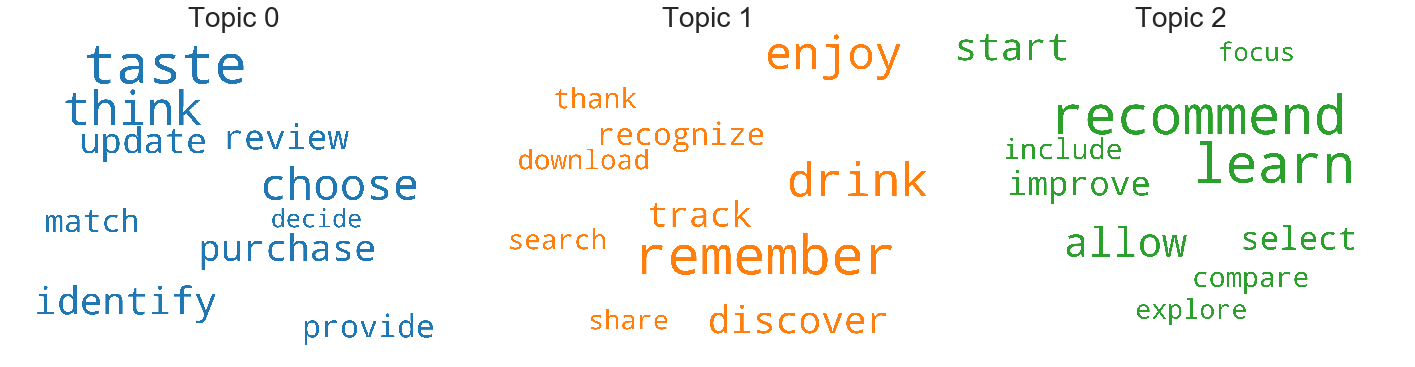

In [169]:
from pprint import pprint
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
# pprint(topics)

# fig, axes = plt.subplots(2, 2, figsize=(20,15), sharex=True, sharey=True)
fig, axes = plt.subplots(1, 3, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=28))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('wordcloud_all_reviews.png')
plt.show()
plt.close()

In [170]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
display(vis)

C:\Users\dbarker3\myAnaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.279276 -0.054957       1        1  35.959316
0      0.190621 -0.198307       2        1  33.054752
2      0.088655  0.253265       3        1  30.985931, topic_info=    Category       Freq        Term      Total  loglift  logprob
5    Default  88.000000   recommend  88.000000  30.0000  30.0000
9    Default  87.000000       learn  87.000000  29.0000  29.0000
15   Default  99.000000    remember  99.000000  28.0000  28.0000
12   Default  84.000000       taste  84.000000  27.0000  27.0000
21   Default  73.000000       drink  73.000000  26.0000  26.0000
..       ...        ...         ...        ...      ...      ...
197   Topic3   4.585103       great   5.146988   1.0560  -5.3444
449   Topic3   4.627396  enthusiast   5.199277   1.0551  -5.3352
30    Topic3   4.278168    maintain   4.849677   1.0462  -5.4137
275   Topic3   4.710046      figure   5.340474   1.0460  -5.3175
116   Topic3   7.083925       write  11.061320   0.7260  -4.9094

[122 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
258       3  0.976862    accurate
76        3  0.943365       agree
1         3  0.996016       allow
33        3  0.840746      appear
66        1  0.957320  appreciate
...     ...       ...         ...
90        2  0.971201      update
468       2  0.884982     upgrade
144       2  0.977479      upload
116       2  0.361620       write
116       3  0.632836       write

[93 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### What do users need?

To determine this, we will filter for reviews <= 3 stars, and perform the same sort of NLP topic analysis

In [22]:
df.head()

,date,text,stars,vivino_response,first_name,last_name,guessed_gender,clean_text,review_lemmas
0,2020-01-15,Super easy to use and very practical. I love wine and I love GOOD wine but I'm new in this business and so like to experience different types. If you want to experiment a bit or just do a quick se...,"[5, 5]",,Dasha,Tuzova,unknown,super practical business experience different types experiment quick search contemplating useful features sales,contemplate
1,2020-01-27,"Overall I like the app. However one niggle relates to adding the location where I purchased the wine. Why can I not specify a location for the wine I purchase, without allowing access to my curren...","[4, 5]",,Paul,de Cort,male,overall niggle relates adding location purchased specify location purchase allowing access current location usually supermarket location drink irrelevant purchased allow search locations current l...,relate add purchase allow purchase allow
2,2020-01-16,"It's quite simply a really useful app to keep track of the wines you've drunk, and though this log and the ratings you give the wines, it'll recommend you other wines in various price groups. It'l...","[5, 5]",,Finn,None,male,simply useful track drunk ratings recommend price groups build taste profile based drink regions,recommend build base
3,2020-01-27,"I use this app mostly when I randomly browsing the wine section of grocery stores and wine shops. Take a picture of the bottle, and you can see the price and reviews. Really helpful when you must ...","[5, 5]",,Helenia,Pan,unknown,randomly browsing section grocery stores shops picture bottle price reviews helpful bottle hurry,browse shop
4,2020-01-23,Great app to get good views on new wines. Great app to determine relative cost for a wine I am considering. Also a good app to provide recommendations for wines similar to the wines I like. VIVINO...,"[5, 5]",,Bob,Junk,male,great views great determine relative considering provide recommendations similar favorite recommended thanked,recommend thank


In [23]:
df1 = df

df1[['user_rank', 'out_of_stars']] = pd.DataFrame(df1['stars'].values.tolist(), index=df1.index)
df1 = df1.drop(columns='stars')
display(df1.head())
display(df1.tail())

,date,text,vivino_response,first_name,last_name,guessed_gender,clean_text,review_lemmas,user_rank,out_of_stars
0,2020-01-15,Super easy to use and very practical. I love wine and I love GOOD wine but I'm new in this business and so like to experience different types. If you want to experiment a bit or just do a quick se...,,Dasha,Tuzova,unknown,super practical business experience different types experiment quick search contemplating useful features sales,contemplate,5,5
1,2020-01-27,"Overall I like the app. However one niggle relates to adding the location where I purchased the wine. Why can I not specify a location for the wine I purchase, without allowing access to my curren...",,Paul,de Cort,male,overall niggle relates adding location purchased specify location purchase allowing access current location usually supermarket location drink irrelevant purchased allow search locations current l...,relate add purchase allow purchase allow,4,5
2,2020-01-16,"It's quite simply a really useful app to keep track of the wines you've drunk, and though this log and the ratings you give the wines, it'll recommend you other wines in various price groups. It'l...",,Finn,None,male,simply useful track drunk ratings recommend price groups build taste profile based drink regions,recommend build base,5,5
3,2020-01-27,"I use this app mostly when I randomly browsing the wine section of grocery stores and wine shops. Take a picture of the bottle, and you can see the price and reviews. Really helpful when you must ...",,Helenia,Pan,unknown,randomly browsing section grocery stores shops picture bottle price reviews helpful bottle hurry,browse shop,5,5
4,2020-01-23,Great app to get good views on new wines. Great app to determine relative cost for a wine I am considering. Also a good app to provide recommendations for wines similar to the wines I like. VIVINO...,,Bob,Junk,male,great views great determine relative considering provide recommendations similar favorite recommended thanked,recommend thank,5,5


,date,text,vivino_response,first_name,last_name,guessed_gender,clean_text,review_lemmas,user_rank,out_of_stars
5711,2015-04-24,Great app This is a great tool. I've been slowly acquiring a taste for wine over the last 10 years. The app is awesome I can just snap a pic and store great wines on my travels.,,T,Jackson,unknown,great great slowly acquiring taste years awesome store great travels,acquire,5,5
5712,2015-03-23,Love it! Would give a 5 star but having issue with the flash in low level lighting. Does not work! Also maybe giving a limited access to cellar function for free!,,Peter,Keating,male,having issue flash level lighting maybe giving limited access cellar function,have light give,4,5
5713,2015-04-08,"Nice! This is a great app. It's a good way to keep track of the wines you love and to look for new ones to try. I love the ""My taste profile"" feature! Very nice interface.",,Destiny,Gaines,female,great track taste profile feature interface,,5,5
5714,2015-03-21,I guess sake is not a wine as evaluated by this app. Need to find an app that works out of the box.,,Chris,Vanslager,mostly_male,guess evaluated works,evaluate,1,5
5715,2015-03-27,"It is good but slow. The idea of app is amasing, but slow from time to time.New update fast it up a bit but it still need work. Results of the photo is offeten false.",,Vlado,Medin,male,amasing update results photo offeten false,amase,5,5


In [24]:
df2 = df1.loc[df1['user_rank'] <= 3]
df2 = df2.reset_index()
display(df2.shape)

(810, 11)

In [25]:
tokenized_reviews = pd.Series(df2['clean_text']).apply(lambda x: x.split())
print(tokenized_reviews[0])

# review_lemmas = lemmatization(tokenized_reviews, tags=['VERB'])
review_lemmas = lemmatization(tokenized_reviews, tags=['NOUN', 'VERB', 'ADJ'])
print(review_lemmas[0])

['great', 'crashes']
['great', 'crash']


In [26]:
review_lemmas2 = []
for i in range(len(review_lemmas)):
    review_lemmas2.append(' '.join(review_lemmas[i]))
    
df2['review_lemmas'] = review_lemmas2

In [27]:
dictionary = corpora.Dictionary(review_lemmas)

In [28]:
doc_term_matrix = [dictionary.doc2bow(review) for review in review_lemmas]

In [29]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100, chunksize=1000, passes=50)
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100, chunksize=1000, passes=50)

#### Print the LDA topics

In [30]:
lda_model.print_topics()

[(0,
  '0.021*"bottle" + 0.019*"price" + 0.016*"wrong" + 0.014*"search" + 0.013*"try" + 0.011*"need" + 0.011*"rating" + 0.010*"label" + 0.008*"vintage" + 0.008*"feature"'),
 (1,
  '0.019*"notification" + 0.014*"email" + 0.014*"review" + 0.012*"photo" + 0.011*"different" + 0.011*"useful" + 0.010*"annoying" + 0.009*"label" + 0.009*"recognize" + 0.008*"phone"'),
 (2,
  '0.041*"update" + 0.026*"work" + 0.018*"camera" + 0.014*"library" + 0.014*"great" + 0.014*"version" + 0.014*"download" + 0.013*"picture" + 0.012*"focus" + 0.012*"try"')]

#### Visualize the topics

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
display(vis)

C:\Users\dbarker3\myAnaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.145311 -0.003425       1        1  37.015881
0      0.076452 -0.096612       2        1  33.040867
1      0.068860  0.100037       3        1  29.943253, topic_info=    Category       Freq          Term      Total  loglift  logprob
61   Default  52.000000        update  52.000000  30.0000  30.0000
98   Default  33.000000          work  33.000000  29.0000  29.0000
56   Default  19.000000  notification  19.000000  28.0000  28.0000
183  Default  21.000000         price  21.000000  27.0000  27.0000
27   Default  26.000000        bottle  26.000000  26.0000  26.0000
..       ...        ...           ...        ...      ...      ...
433   Topic3   5.618312          scan  16.047964   0.1563  -5.2087
314   Topic3   5.027424         month  12.255943   0.3148  -5.3198
124   Topic3   5.439580        screen  15.347281   0.1686  -5.2410
253   Topic3   5.507368       picture  23.880123  -0.2611  -5.2287
146   Topic3   5.664440           try  35.413574  -0.6270  -5.2005

[185 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
144       1  0.312337   account
144       2  0.187402   account
144       3  0.499739   account
467       2  0.726459  accurate
467       3  0.290584  accurate
...     ...       ...       ...
121       2  0.129001     waste
98        1  0.988056      work
169       1  0.129972     wrong
169       2  0.779832     wrong
169       3  0.086648     wrong

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

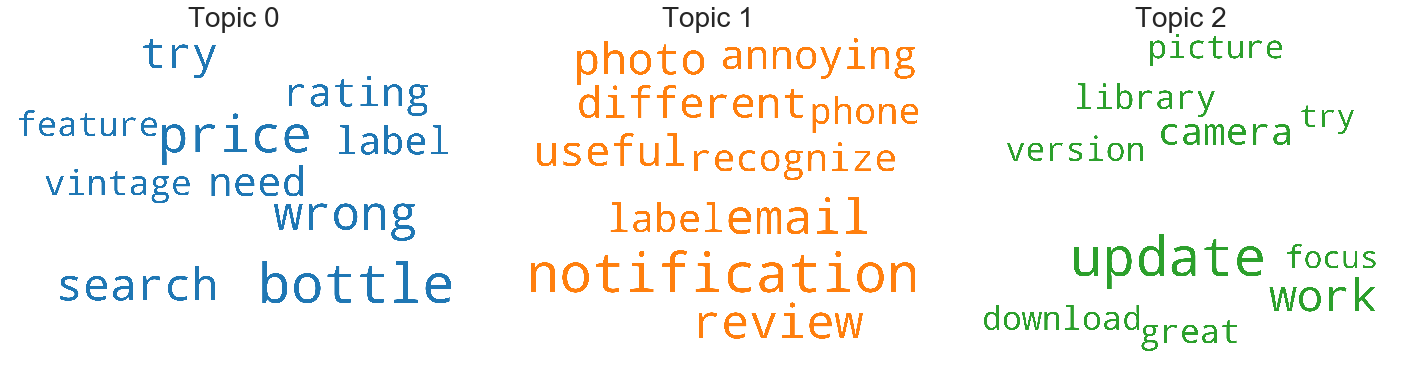

In [41]:
from pprint import pprint
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
# pprint(topics)

fig, axes = plt.subplots(1, 3, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=28))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('wordcloud_1-3_star_reviews.png')
plt.show()
plt.close()